#Pre-processing of Image dataset using flower dataset.



### Setup

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)

2.11.0


### Download the flowers dataset

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

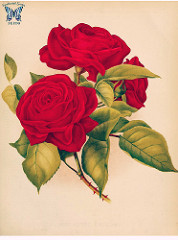

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[7]))

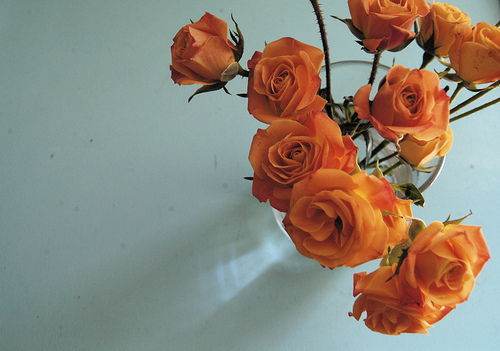

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[20]))

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first five images from the training dataset.

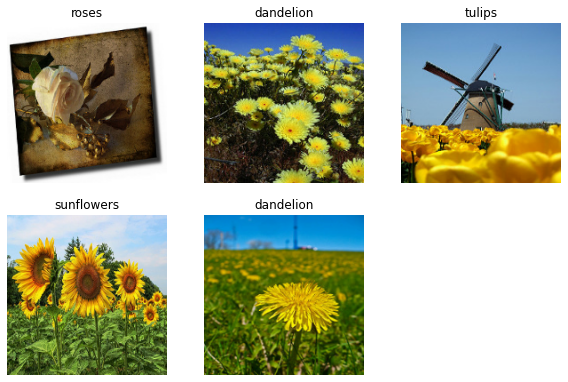

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

I train a model using these datasets by passing them to `model.fit`

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

92/92 [==============================] - 9s 80ms/step - loss: 1.3037 - accuracy: 0.4343 - val_loss: 1.0723 - val_accuracy: 0.5736


## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/15049902081_dd85361f8c_m.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/6080086410_17a02dcfb8.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/5139971615_434ff8ed8b_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/18282528206_7fb3166041.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/7280222348_a87725ca77.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

print the length of each dataset as follows:

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  2


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

visualize this dataset similarly to created previously:

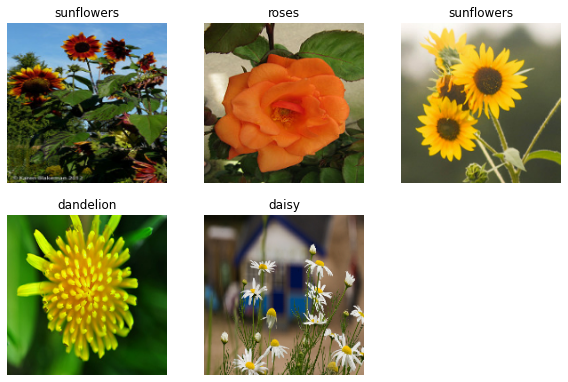

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(5):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model


In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 8s 75ms/step - loss: 1.0282 - accuracy: 0.6015 - val_loss: 1.1001 - val_accuracy: 0.5749
Epoch 2/3
92/92 [==============================] - 2s 27ms/step - loss: 0.8738 - accuracy: 0.6567 - val_loss: 0.8686 - val_accuracy: 0.6689
Epoch 3/3
92/92 [==============================] - 2s 27ms/step - loss: 0.7449 - accuracy: 0.7190 - val_loss: 0.8653 - val_accuracy: 0.6580


In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes:

In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset:

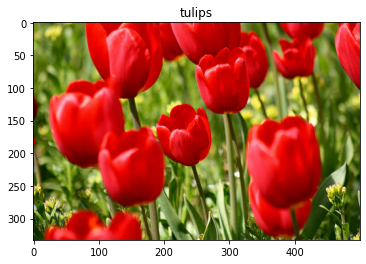

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)